<a href="https://colab.research.google.com/github/kriskalb/energy-market-analysis/blob/main/energy_market_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import math
import warnings
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBRegressor

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [ ]:
!pip install prophet

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Kurs/energy_market_analysis/20240206_notowania_RTT_ee_gaz_eua_na_rekrutacje_od_2023_v2.xlsx', header=1)

# Initial analysis and data processing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quotation_date                      3511 non-null   object 
 1   delivery_date_from                  3511 non-null   object 
 2   delivery_date_to                    3511 non-null   object 
 3   instrument_name                     3511 non-null   object 
 4   instrument_kind                     3511 non-null   object 
 5   settlement_price                    3511 non-null   float64
 6   low_price                           2399 non-null   float64
 7   high_price                          2399 non-null   float64
 8   total_volume_mwh                    3511 non-null   int64  
 9   lots_mw                             3511 non-null   int64  
 10  turnover_value                      3511 non-null   float64
 11  transactions_number                 3511 no

In [ ]:
df['quotation_date'] = pd.to_datetime(df['quotation_date'], format='%Y-%m-%d')
df['delivery_date_from'] = pd.to_datetime(df['delivery_date_from'], format='%Y-%m-%d')
df['delivery_date_to'] = pd.to_datetime(df['delivery_date_to'], format='%Y-%m-%d')

In [ ]:
df['quotation_day'] = pd.to_datetime(df['quotation_date']).dt.day
df['quotation_dow'] = pd.to_datetime(df['quotation_date']).dt.dayofweek

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quotation_date                      3511 non-null   datetime64[ns]
 1   delivery_date_from                  3511 non-null   datetime64[ns]
 2   delivery_date_to                    3511 non-null   datetime64[ns]
 3   instrument_name                     3511 non-null   object        
 4   instrument_kind                     3511 non-null   object        
 5   settlement_price                    3511 non-null   float64       
 6   low_price                           2399 non-null   float64       
 7   high_price                          2399 non-null   float64       
 8   total_volume_mwh                    3511 non-null   int64         
 9   lots_mw                             3511 non-null   int64         
 10  turnover_value          

In [ ]:
df.head()

,quotation_date,delivery_date_from,delivery_date_to,instrument_name,instrument_kind,settlement_price,low_price,high_price,total_volume_mwh,lots_mw,turnover_value,transactions_number,total_number_of_open_interests_mwh,open_price,close_price,quotation_month,delivery_month,id,quotation_day,quotation_dow
0,2023-01-02,2023-02-01,2023-02-28,BASE_M-02-23,BASE,834.80,825.0,850.0,23520,35,19612320.0,27,55776,NaN,NaN,1,2,965,2,0
1,2023-01-02,2023-03-01,2023-03-31,BASE_M-03-23,BASE,790.00,785.0,810.0,10402,14,8236155.0,12,31949,NaN,NaN,1,3,965,2,0
2,2023-01-02,2023-04-01,2023-06-30,BASE_Q-2-23,BASE,810.90,804.0,825.0,54600,25,44459688.0,25,340704,NaN,NaN,1,4,965,2,0
3,2023-01-02,2023-07-01,2023-09-30,BASE_Q-3-23,BASE,875.00,875.0,899.0,26496,12,23236992.0,11,198720,NaN,NaN,1,7,965,2,0
4,2023-01-02,2023-10-01,2023-12-31,BASE_Q-4-23,BASE,926.33,926.0,927.0,13254,6,12277622.0,6,558877,NaN,NaN,1,10,965,2,0


In [ ]:
df.drop(columns=['open_price', 'close_price', 'instrument_kind'], inplace=True)

In [ ]:
for column in df.columns:
  unique_count = len(df[column].unique())
  print(f'{column} \t {unique_count} unique values')

quotation_date 	 275 unique values
delivery_date_from 	 78 unique values
delivery_date_to 	 78 unique values
instrument_name 	 86 unique values
settlement_price 	 2183 unique values
low_price 	 649 unique values
high_price 	 643 unique values
total_volume_mwh 	 583 unique values
lots_mw 	 152 unique values
turnover_value 	 2331 unique values
transactions_number 	 90 unique values
total_number_of_open_interests_mwh 	 1853 unique values
quotation_month 	 12 unique values
delivery_month 	 12 unique values
id 	 275 unique values
quotation_day 	 31 unique values
quotation_dow 	 5 unique values


In [ ]:
df['instrument_name'].unique()

In [ ]:
df_base_m = df[df['instrument_name'].str.startswith("BASE_M")]

In [ ]:
df_base_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 0 to 3503
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quotation_date                      879 non-null    datetime64[ns]
 1   delivery_date_from                  879 non-null    datetime64[ns]
 2   delivery_date_to                    879 non-null    datetime64[ns]
 3   instrument_name                     879 non-null    object        
 4   settlement_price                    879 non-null    float64       
 5   low_price                           700 non-null    float64       
 6   high_price                          700 non-null    float64       
 7   total_volume_mwh                    879 non-null    int64         
 8   lots_mw                             879 non-null    int64         
 9   turnover_value                      879 non-null    float64       
 10  transactions_number      

In [ ]:
for column in df_base_m.columns:
  unique_count = len(df_base_m[column].unique())
  print(f'{column} \t {unique_count} unique values')

quotation_date 	 275 unique values
delivery_date_from 	 17 unique values
delivery_date_to 	 17 unique values
instrument_name 	 17 unique values
settlement_price 	 758 unique values
low_price 	 326 unique values
high_price 	 322 unique values
total_volume_mwh 	 230 unique values
lots_mw 	 92 unique values
turnover_value 	 692 unique values
transactions_number 	 73 unique values
total_number_of_open_interests_mwh 	 547 unique values
quotation_month 	 12 unique values
delivery_month 	 12 unique values
id 	 275 unique values
quotation_day 	 31 unique values
quotation_dow 	 5 unique values


In [ ]:
# Asign contract type by counting month difference between delivery and quotation
df_base_m['month_difference'] = (df_base_m['delivery_date_from'].dt.to_period('M').astype(int) - df_base_m['quotation_date'].dt.to_period('M').astype(int))
df_base_m['contract_type'] = 'M+' + (df_base_m['month_difference']).astype(str)
df_base_m.loc[df_base_m['month_difference'] > 2, 'contract_type'] = 'M+3'


In [ ]:
df_base_m.head()

,quotation_date,delivery_date_from,delivery_date_to,instrument_name,settlement_price,low_price,high_price,total_volume_mwh,lots_mw,turnover_value,transactions_number,total_number_of_open_interests_mwh,quotation_month,delivery_month,id,quotation_day,quotation_dow,month_difference,contract_type
0,2023-01-02,2023-02-01,2023-02-28,BASE_M-02-23,834.80,825.0,850.0,23520,35,19612320.0,27,55776,1,2,965,2,0,1,M+1
1,2023-01-02,2023-03-01,2023-03-31,BASE_M-03-23,790.00,785.0,810.0,10402,14,8236155.0,12,31949,1,3,965,2,0,2,M+2
9,2023-01-03,2023-02-01,2023-02-28,BASE_M-02-23,820.80,815.0,830.0,18816,28,15442224.0,21,61824,1,2,966,3,1,1,M+1
10,2023-01-03,2023-03-01,2023-03-31,BASE_M-03-23,781.25,775.0,785.0,3715,5,2905130.0,4,32692,1,3,966,3,1,2,M+2
19,2023-01-04,2023-02-01,2023-02-28,BASE_M-02-23,800.50,795.0,805.0,19488,29,15568560.0,25,69216,1,2,967,4,2,1,M+1


In [ ]:
df_final = df_base_m[df_base_m['month_difference'] <= 2]

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 3501
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quotation_date                      530 non-null    datetime64[ns]
 1   delivery_date_from                  530 non-null    datetime64[ns]
 2   delivery_date_to                    530 non-null    datetime64[ns]
 3   instrument_name                     530 non-null    object        
 4   settlement_price                    530 non-null    float64       
 5   low_price                           497 non-null    float64       
 6   high_price                          497 non-null    float64       
 7   total_volume_mwh                    530 non-null    int64         
 8   lots_mw                             530 non-null    int64         
 9   turnover_value                      530 non-null    float64       
 10  transactions_number      

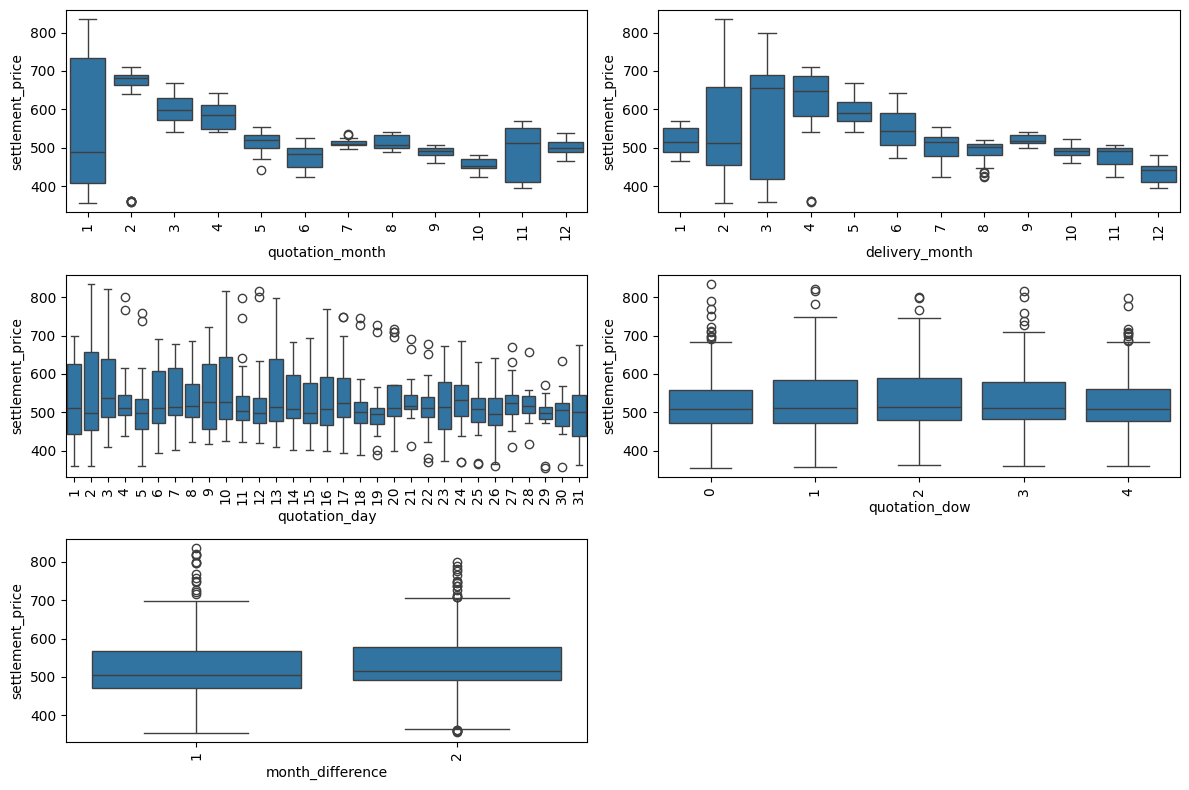

In [ ]:
plt.figure(figsize=(12, 8))

# month_difference
plt.subplot(3, 2, 1)
sns.boxplot(x='quotation_month', y='settlement_price', data=df_final)
plt.xticks(rotation=90)

# month_difference
plt.subplot(3, 2, 2)
sns.boxplot(x='delivery_month', y='settlement_price', data=df_final)
plt.xticks(rotation=90)

# month_difference
plt.subplot(3, 2, 3)
sns.boxplot(x='quotation_day', y='settlement_price', data=df_final)
plt.xticks(rotation=90)

# month_difference
plt.subplot(3, 2, 4)
sns.boxplot(x='quotation_dow', y='settlement_price', data=df_final)
plt.xticks(rotation=90)

# month_difference
plt.subplot(3, 2, 5)
sns.boxplot(x='month_difference', y='settlement_price', data=df_final)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

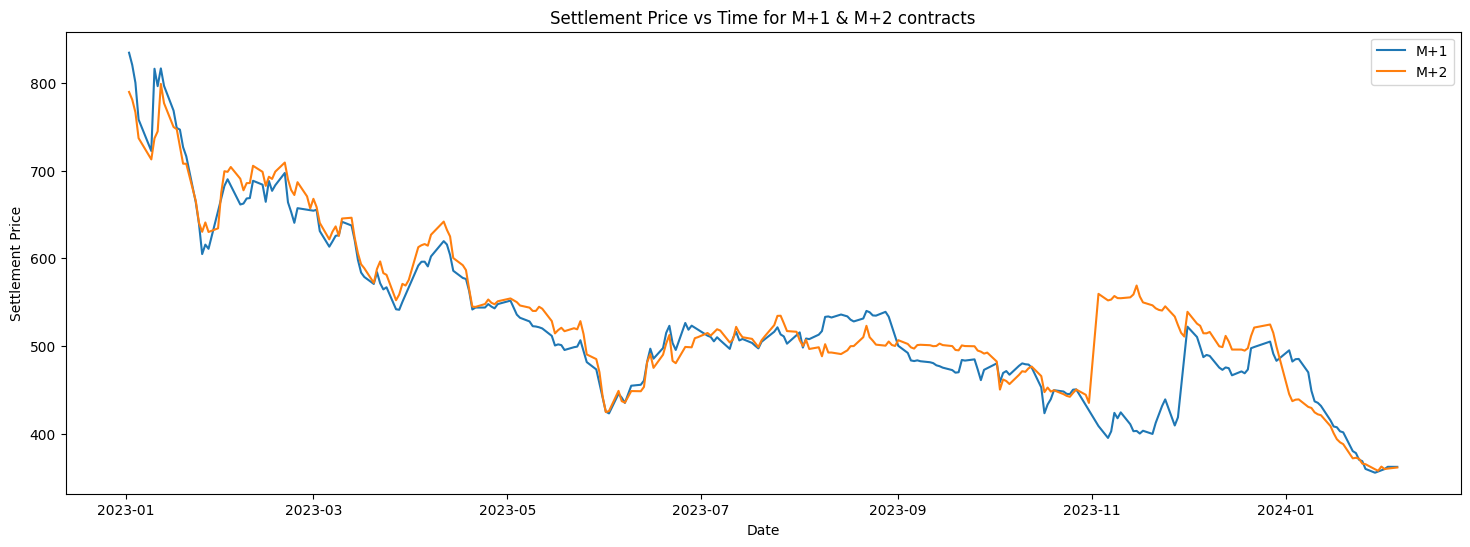

In [ ]:
df_month_1 = df_final[df_final['month_difference'] == 1]
df_month_2 = df_final[df_final['month_difference'] == 2]

plt.figure(figsize=(18, 6))
plt.plot(df_month_1['quotation_date'], df_month_1['settlement_price'], label='M+1')
plt.plot(df_month_2['quotation_date'], df_month_2['settlement_price'], label='M+2')

plt.xlabel('Date')
plt.ylabel('Settlement Price')
plt.title('Settlement Price vs Time for M+1 & M+2 contracts')
plt.legend()

plt.show()

In [ ]:
df_month_1 = df_final[df_final['month_difference'] == 1].set_index('quotation_date')[['settlement_price']].rename(columns={'settlement_price': 'settlement_price_M1'})
df_month_2 = df_final[df_final['month_difference'] == 2].set_index('quotation_date')[['settlement_price']].rename(columns={'settlement_price': 'settlement_price_M2'})
df_combined = pd.concat([df_month_1, df_month_2], axis=1).dropna()

In [ ]:
df_combined['spread'] = df_combined['settlement_price_M2'].sub(df_combined['settlement_price_M1'])

In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2023-01-02 to 2024-02-05
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   settlement_price_M1  255 non-null    float64
 1   settlement_price_M2  255 non-null    float64
 2   spread               255 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB


In [ ]:
df_combined.describe()

,settlement_price_M1,settlement_price_M2,spread
count,255.000000,255.000000,255.000000
mean,525.744745,538.291569,12.546824
std,96.867144,91.398423,39.588305
min,355.270000,359.220000,-79.490000
25%,471.140000,492.995000,-6.325000
50%,505.000000,514.900000,8.690000
75%,568.900000,582.175000,19.760000
max,834.800000,799.200000,166.000000


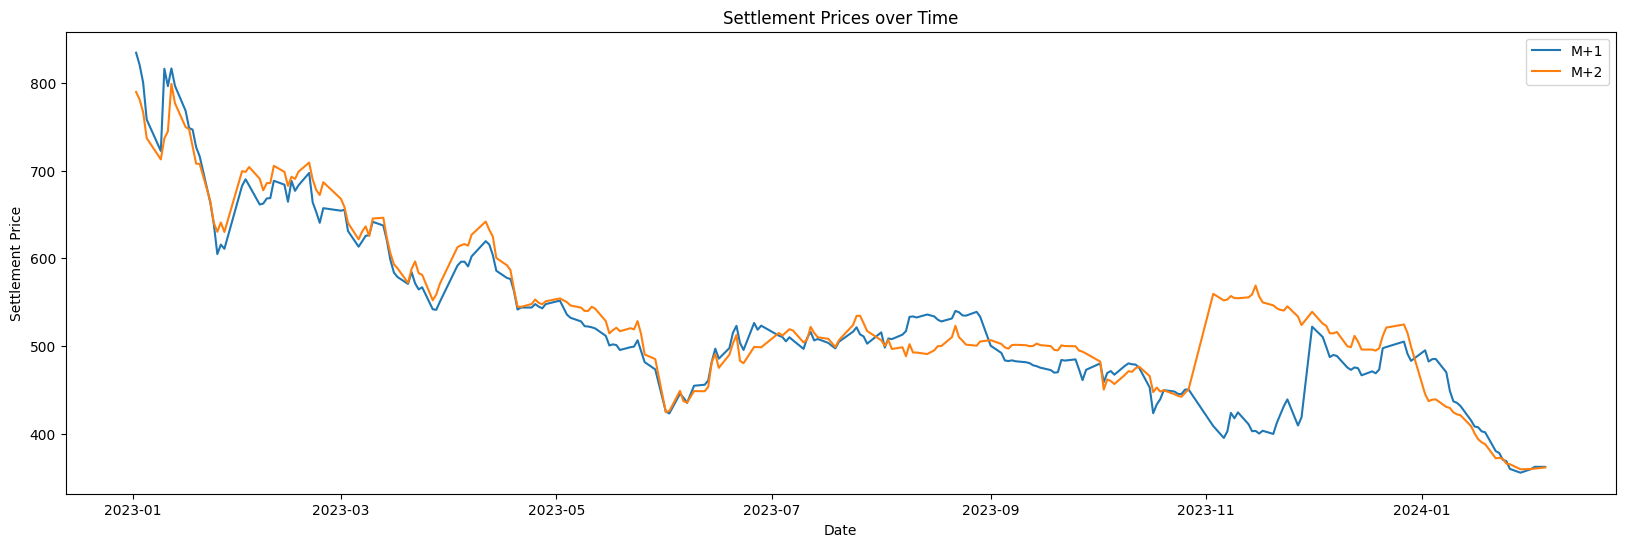

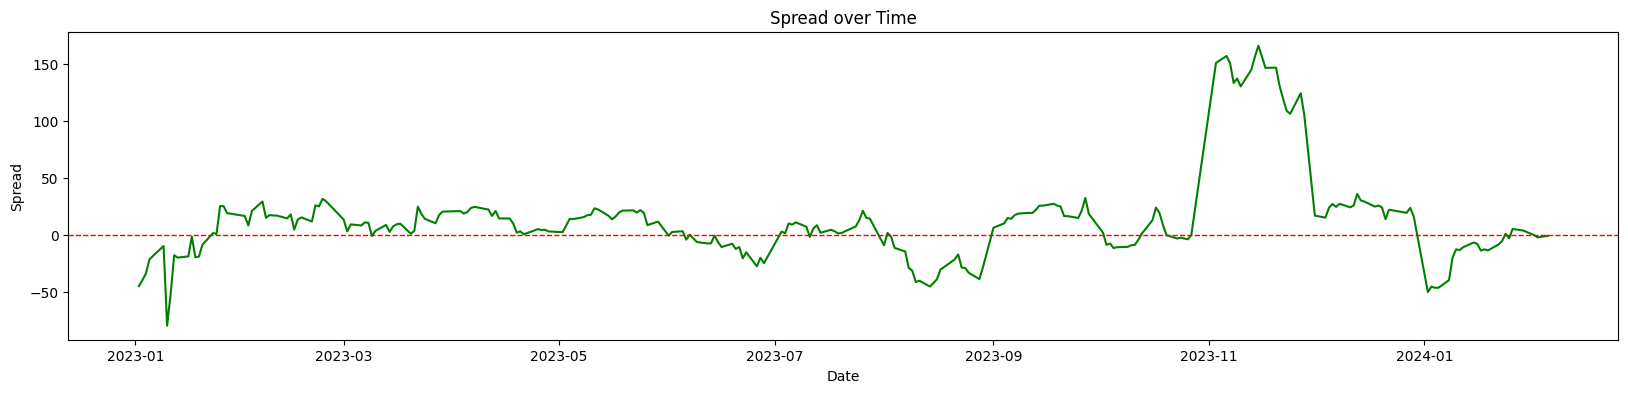

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df_combined.index, df_combined['settlement_price_M1'], label='M+1')
plt.plot(df_combined.index, df_combined['settlement_price_M2'], label='M+2')
plt.xlabel('Date')
plt.ylabel('Settlement Price')
plt.title('Settlement Prices over Time')
plt.legend()
plt.show()

# Wykres dla spread
plt.figure(figsize=(20, 4))
plt.plot(df_combined.index, df_combined['spread'], color='green')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread over Time')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.show()

# Prophet model to predict spreads between M+1 & M+2 contracts

In [ ]:
df_prophet = df_combined.copy()
del df_prophet['settlement_price_M1']
del df_prophet['settlement_price_M2']

df_prophet = df_prophet.reset_index()
df_prophet = df_prophet.rename(columns={'quotation_date':'ds', 'spread':'y'})
df_prophet.head()

,ds,y
0,2023-01-02,-44.80
1,2023-01-03,-39.55
2,2023-01-04,-33.75
3,2023-01-05,-21.25
4,2023-01-09,-9.60


In [ ]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      255 non-null    datetime64[ns]
 1   y       255 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


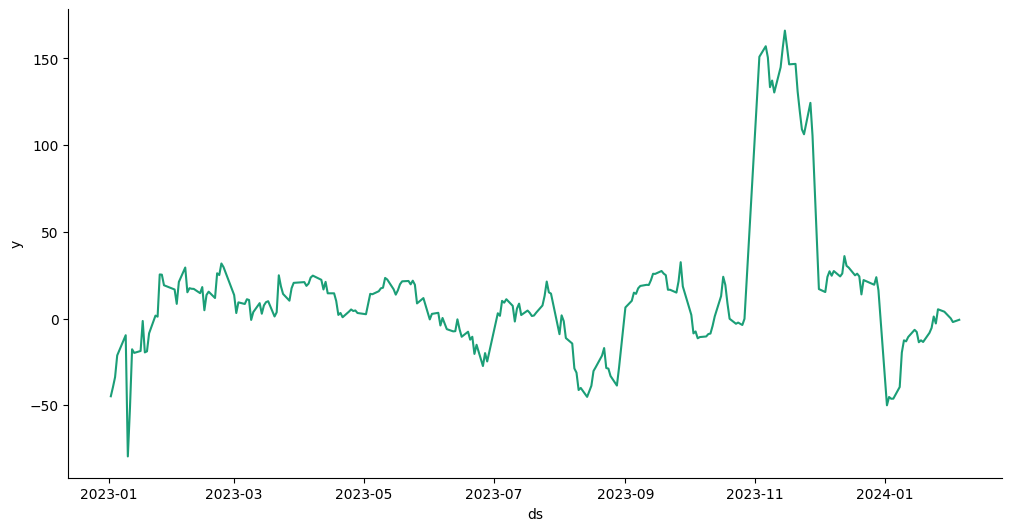

In [ ]:
# @title ds vs y

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_prophet.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

In [ ]:
df_prophet['ds'].dt.month[df_prophet['ds'].dt.month == 8].count()

20

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/tj33upgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/zwq_w6i0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37647', 'data', 'file=/tmp/tmpsg63idui/tj33upgu.json', 'init=/tmp/tmpsg63idui/zwq_w6i0.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelu9zmbdmk/prophet_model-20240218153836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


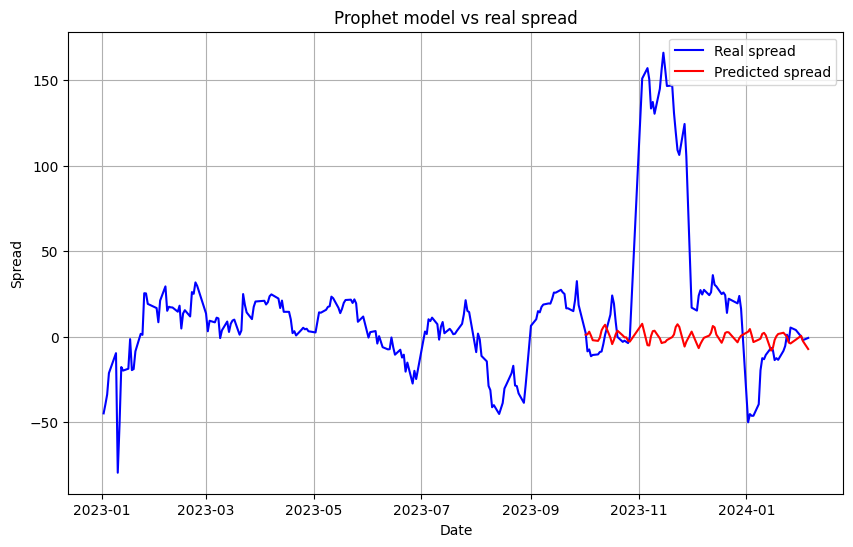

In [ ]:
# Prophet model
model = Prophet(
      yearly_seasonality=False,
      weekly_seasonality=True,
      daily_seasonality=False,
      seasonality_prior_scale=10,
      changepoint_prior_scale=0.05,
      growth='linear'
)
model.add_seasonality(name='monthly', period=20, fourier_order=5)

train_data = df_prophet.iloc[:175]

model.fit(train_data)

future_dates = df_prophet.iloc[175:]['ds']

forecast = model.predict(pd.DataFrame({'ds': future_dates}))

plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Real spread', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted spread', color='red')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Prophet model vs real spread')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
horizon = 20
window_size = 60

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/n1f1z5ks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/gxf5j7rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48076', 'data', 'file=/tmp/tmpsg63idui/n1f1z5ks.json', 'init=/tmp/tmpsg63idui/gxf5j7rc.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelv5hdzuvw/prophet_model-20240218121131.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


okres treningowy: (0, 60)
okres testowy: (60, 80)


12:11:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


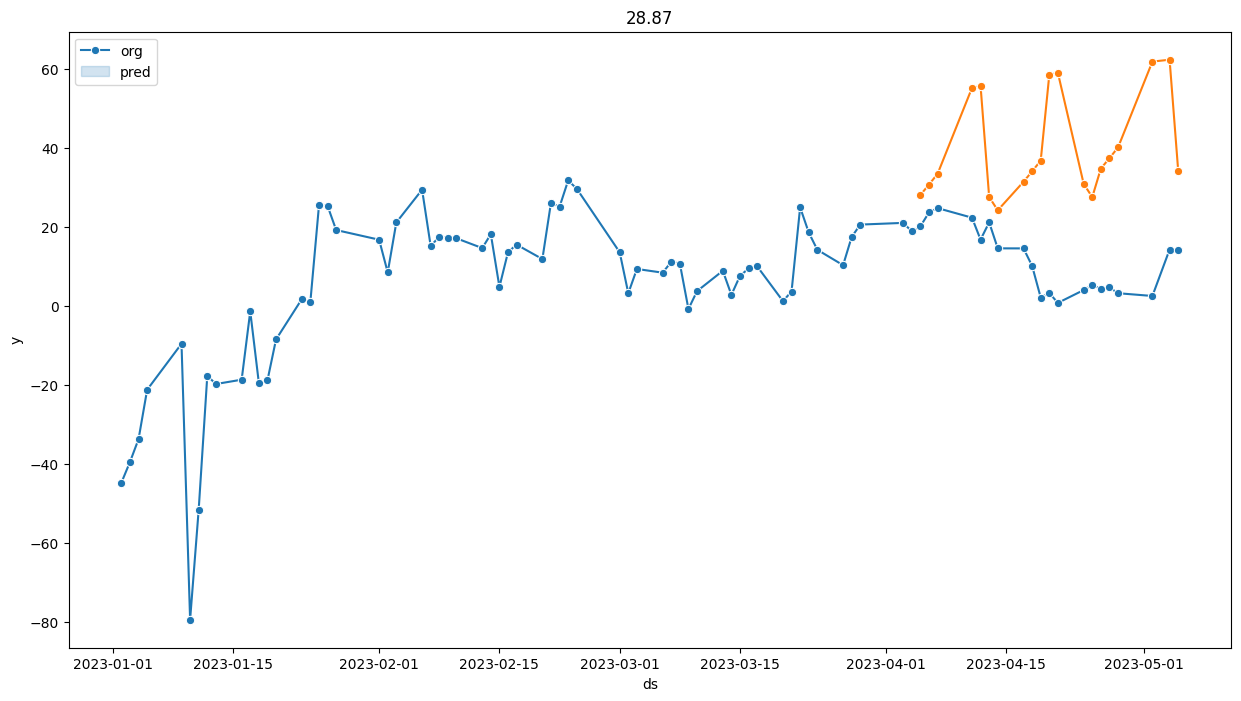

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/vorikona.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/w7i7bw7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25556', 'data', 'file=/tmp/tmpsg63idui/vorikona.json', 'init=/tmp/tmpsg63idui/w7i7bw7r.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelx3owskx4/prophet_model-20240218121132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute error for 20 days ahead forecast: 28.87
okres treningowy: (20, 80)
okres testowy: (80, 100)


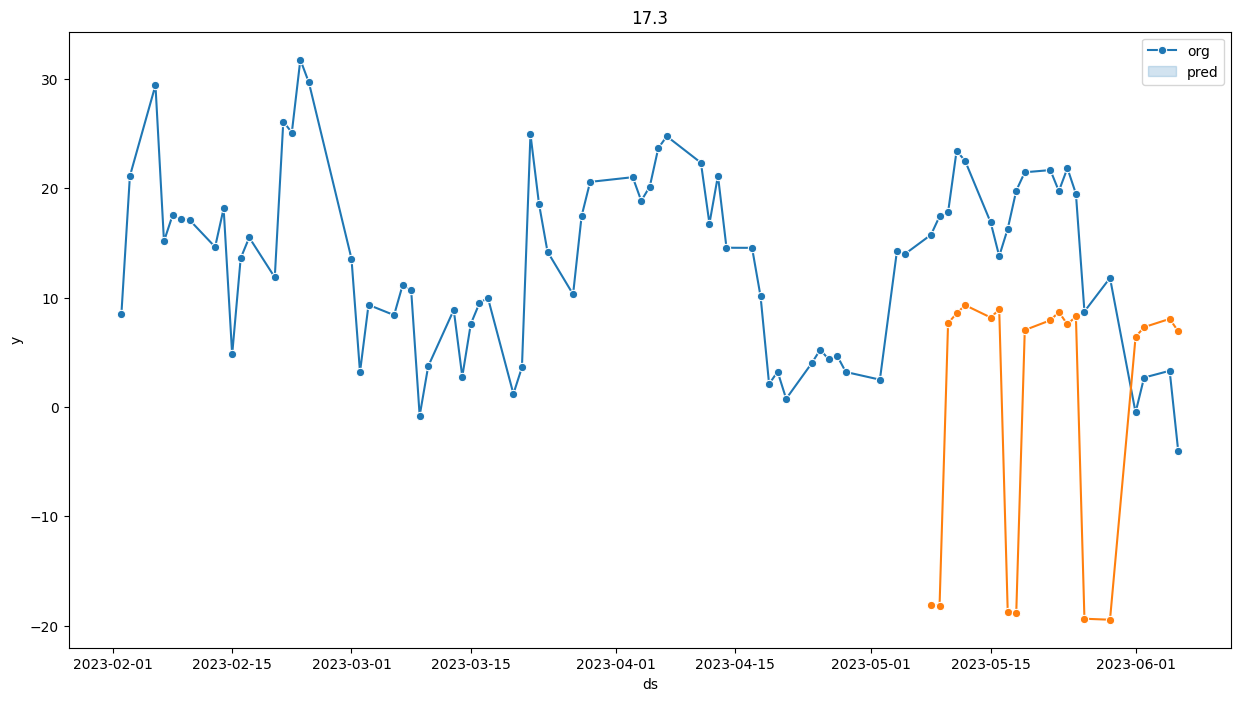

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/pyh2cq1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/h9_5xghp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88628', 'data', 'file=/tmp/tmpsg63idui/pyh2cq1i.json', 'init=/tmp/tmpsg63idui/h9_5xghp.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelqopgw1nl/prophet_model-20240218121132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean absolute error for 20 days ahead forecast: 17.30
okres treningowy: (40, 100)
okres testowy: (100, 120)


12:11:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


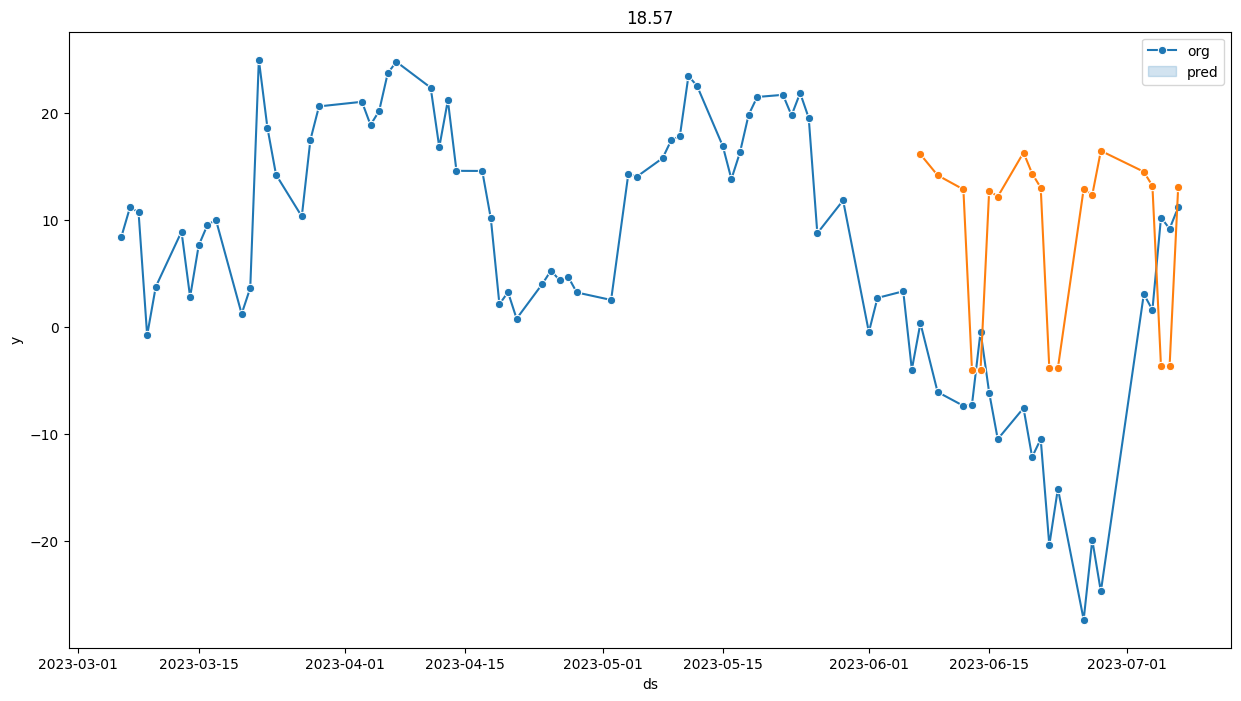

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/6t9ybcu6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/e67utlxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71227', 'data', 'file=/tmp/tmpsg63idui/6t9ybcu6.json', 'init=/tmp/tmpsg63idui/e67utlxe.json', 'output', 'file=/tmp/tmpsg63idui/prophet_model_mwtszn0/prophet_model-20240218121133.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute error for 20 days ahead forecast: 18.57
okres treningowy: (60, 120)
okres testowy: (120, 140)


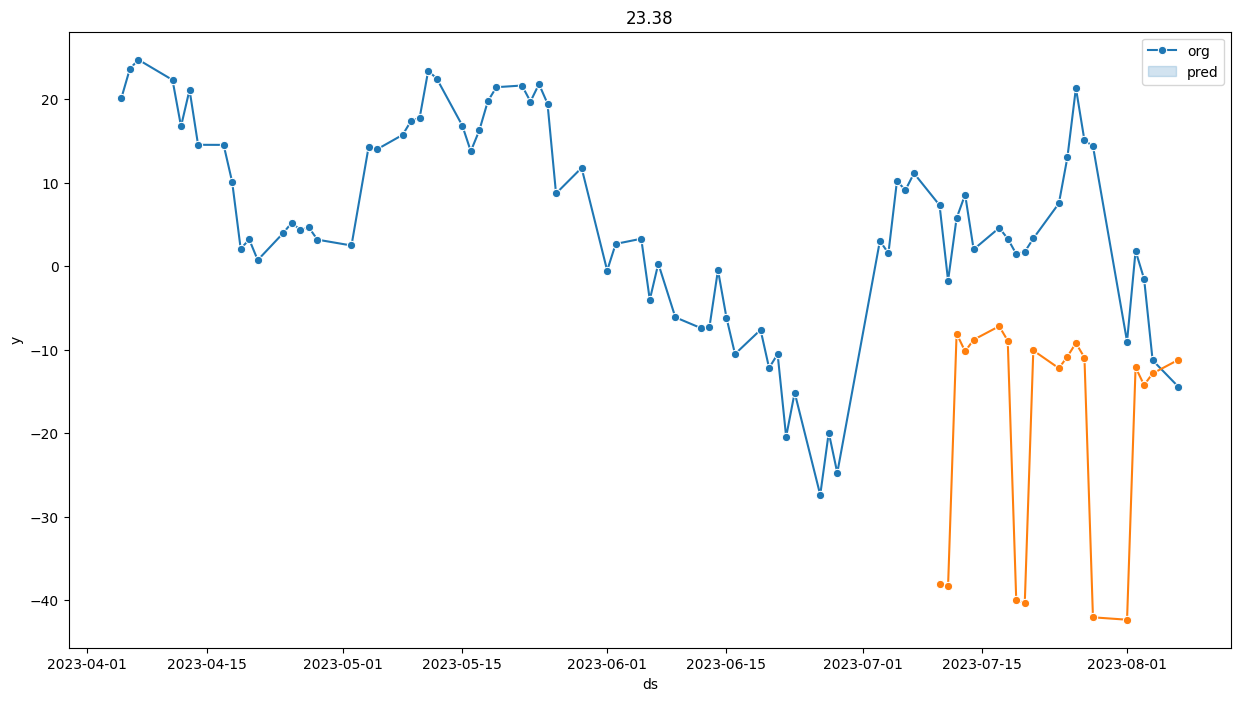

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/jhv0wj54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/yxcnj69j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49461', 'data', 'file=/tmp/tmpsg63idui/jhv0wj54.json', 'init=/tmp/tmpsg63idui/yxcnj69j.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelda3hvg7d/prophet_model-20240218121134.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean absolute error for 20 days ahead forecast: 23.38
okres treningowy: (80, 140)
okres testowy: (140, 160)


12:11:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


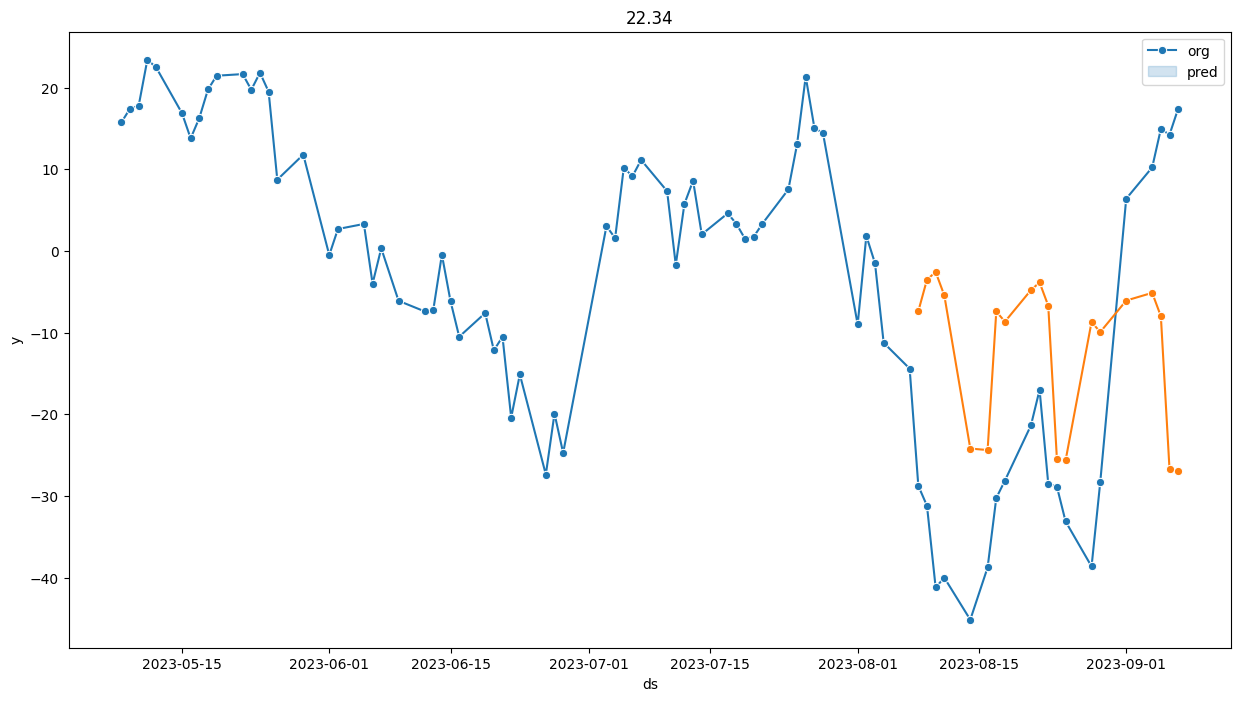

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/beog9l3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/u67x_dxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65549', 'data', 'file=/tmp/tmpsg63idui/beog9l3q.json', 'init=/tmp/tmpsg63idui/u67x_dxi.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelur51dhto/prophet_model-20240218121134.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean absolute error for 20 days ahead forecast: 22.34
okres treningowy: (100, 160)
okres testowy: (160, 180)


12:11:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


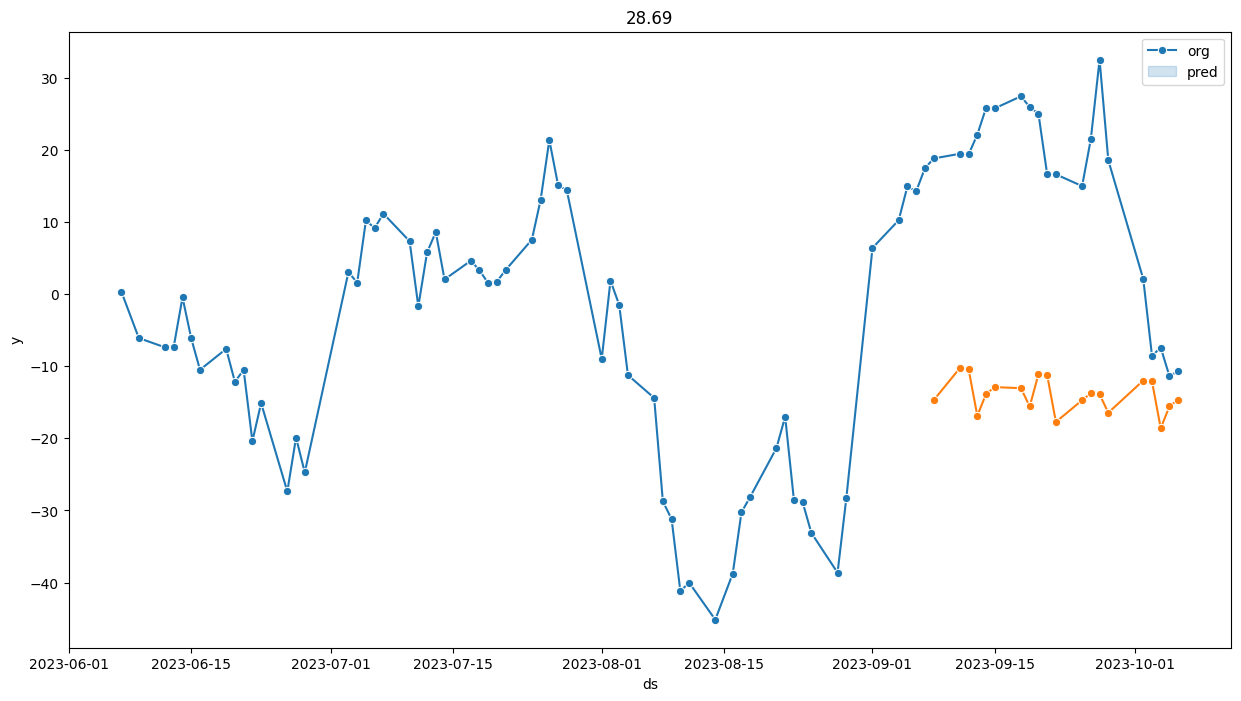

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/6gcxioj4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/u6ev0fs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40840', 'data', 'file=/tmp/tmpsg63idui/6gcxioj4.json', 'init=/tmp/tmpsg63idui/u6ev0fs7.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modeleokog086/prophet_model-20240218121135.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean absolute error for 20 days ahead forecast: 28.69
okres treningowy: (120, 180)
okres testowy: (180, 200)


12:11:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


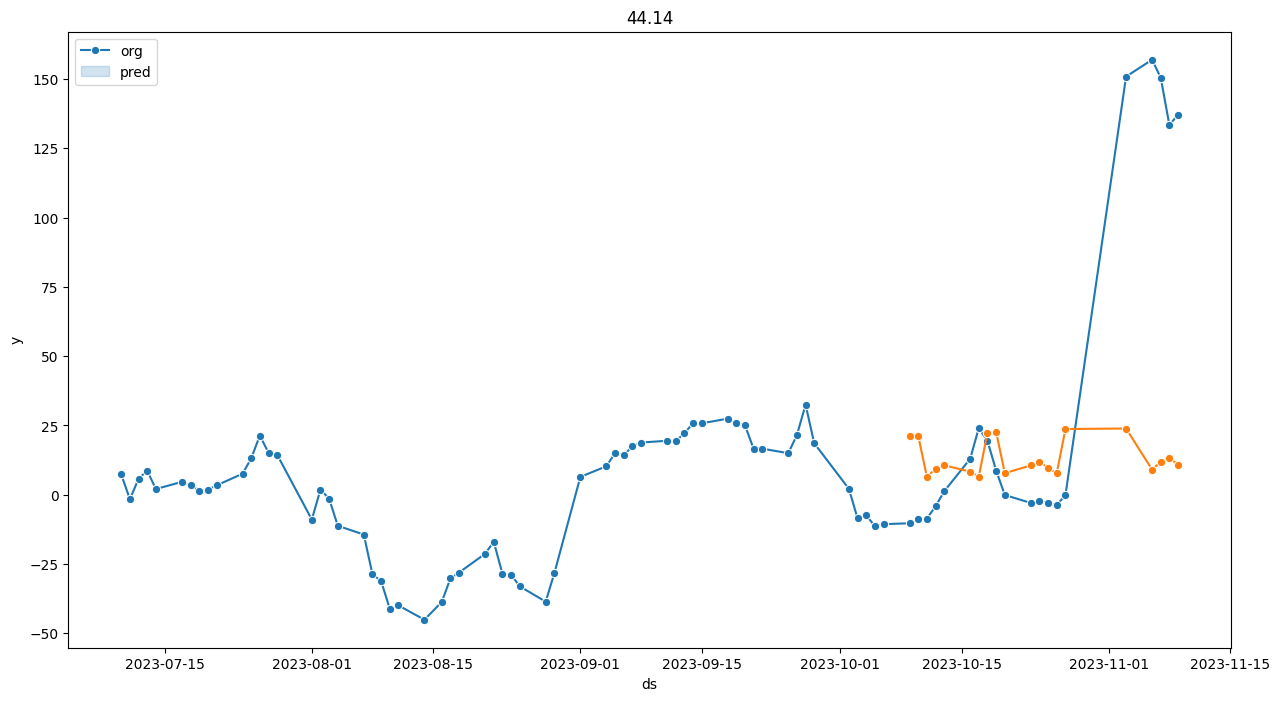

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/bttc9y4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/_c3ppx0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70575', 'data', 'file=/tmp/tmpsg63idui/bttc9y4p.json', 'init=/tmp/tmpsg63idui/_c3ppx0q.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelnhuuxcza/prophet_model-20240218121136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean absolute error for 20 days ahead forecast: 44.14
okres treningowy: (140, 200)
okres testowy: (200, 220)


12:11:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


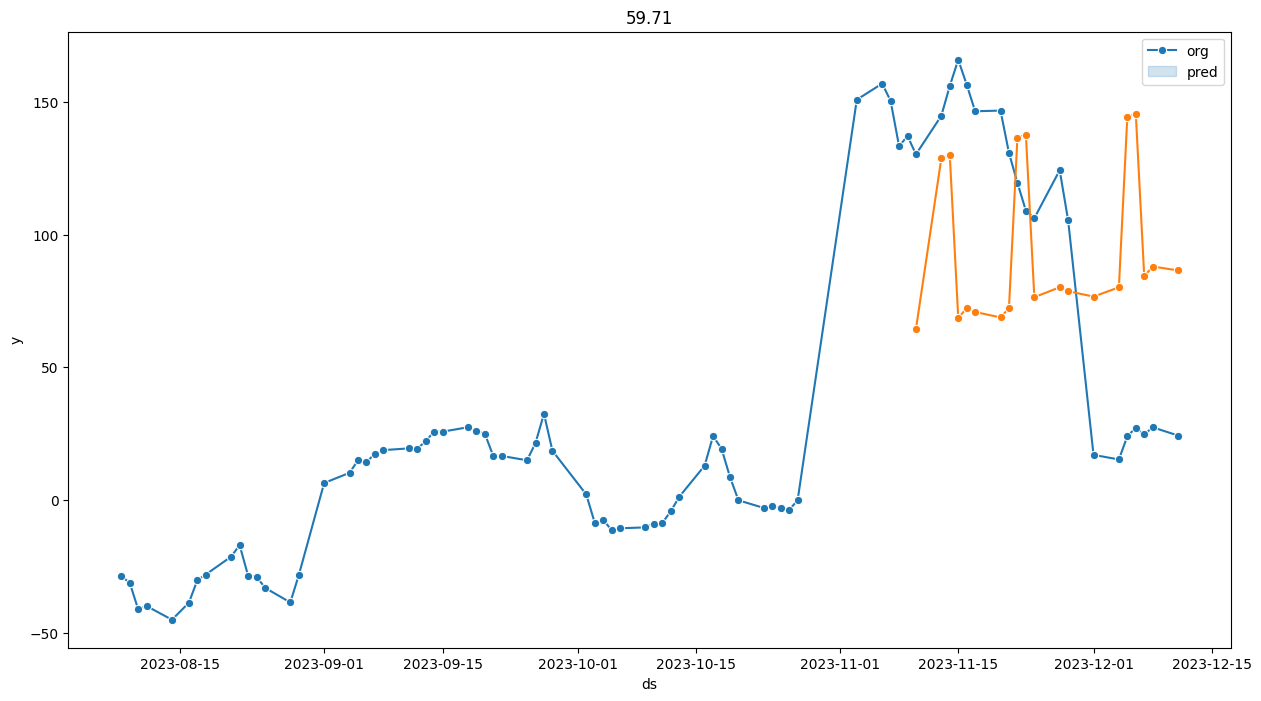

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/5t666hr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsg63idui/uszivkni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2149', 'data', 'file=/tmp/tmpsg63idui/5t666hr1.json', 'init=/tmp/tmpsg63idui/uszivkni.json', 'output', 'file=/tmp/tmpsg63idui/prophet_modelvoalb0ev/prophet_model-20240218121137.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute error for 20 days ahead forecast: 59.71
okres treningowy: (160, 220)
okres testowy: (220, 240)


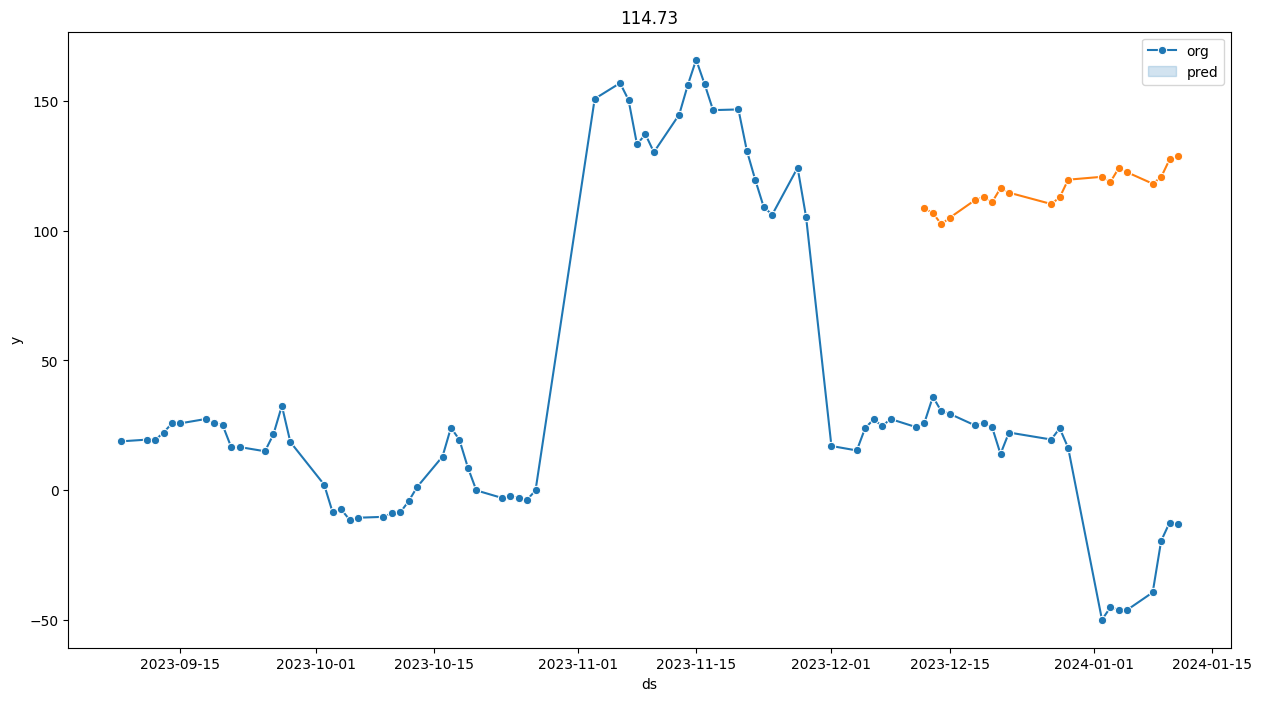

Mean absolute error for 20 days ahead forecast: 114.73


In [ ]:
maes_prophet = []

for i in range(0, len(df_prophet) - horizon - window_size, horizon):
  print(f"Train period: {i, i + window_size}")
  print(f"Test period: {i + window_size, i + window_size +horizon }")
  train = df_prophet.iloc[i:i + window_size ]
  test = df_prophet.iloc[i + window_size: i + window_size +horizon ]


  model = Prophet(
      # yearly_seasonality=False,
      # weekly_seasonality=True,
      # daily_seasonality=False,
      # seasonality_prior_scale=10,
      # changepoint_prior_scale=0.05,
      # growth='linear'
  )
  # model.add_seasonality(name='monthly', period=20, fourier_order=1)

  model.fit(train)
  future_dates = model.make_future_dataframe(periods=horizon, freq='D', include_history=False)
  forecast = model.predict(future_dates)
  y_true = test['y']
  y_pred = forecast['yhat']

  test['pred'] = forecast['yhat'].values
  all = pd.concat([train, test])

  all['pred'] = all['pred']
  all['y'] = all['y']

  plt.figure(figsize = (15, 8))
  sns.lineplot(x = 'ds', y = 'y', data = all, marker = 'o' )
  sns.lineplot(x = 'ds', y = 'pred', data = all, marker = 'o' )
  plt.title(mae(y_true, y_pred).round(2) )
  plt.legend(['org','pred'])
  plt.show()
  print(f'Mean absolute error for {horizon} days ahead forecast: {mae(y_true, y_pred) :.2f}')

  maes_prophet.append(mae(y_true, y_pred))

In [ ]:
np.mean(maes_prophet)

39.74882522946

#XGBoost Regression Model

In [ ]:
df_final.head()

,quotation_date,delivery_date_from,delivery_date_to,instrument_name,settlement_price,low_price,high_price,total_volume_mwh,lots_mw,turnover_value,transactions_number,total_number_of_open_interests_mwh,quotation_month,delivery_month,id,quotation_day,quotation_dow,month_difference,contract_type
0,2023-01-02,2023-02-01,2023-02-28,BASE_M-02-23,834.80,825.0,850.0,23520,35,19612320.0,27,55776,1,2,965,2,0,1,M+1
1,2023-01-02,2023-03-01,2023-03-31,BASE_M-03-23,790.00,785.0,810.0,10402,14,8236155.0,12,31949,1,3,965,2,0,2,M+2
9,2023-01-03,2023-02-01,2023-02-28,BASE_M-02-23,820.80,815.0,830.0,18816,28,15442224.0,21,61824,1,2,966,3,1,1,M+1
10,2023-01-03,2023-03-01,2023-03-31,BASE_M-03-23,781.25,775.0,785.0,3715,5,2905130.0,4,32692,1,3,966,3,1,2,M+2
19,2023-01-04,2023-02-01,2023-02-28,BASE_M-02-23,800.50,795.0,805.0,19488,29,15568560.0,25,69216,1,2,967,4,2,1,M+1


In [ ]:
month_1_columns = ['settlement_price', 'quotation_month', 'quotation_day', 'quotation_dow', 'delivery_month']

In [ ]:
df_month_1 = df_final[df_final['month_difference'] == 1].set_index('quotation_date')[month_1_columns].rename(columns={'settlement_price': 'settlement_price_M1', 'delivery_month':'M1_delivery_month'})
df_month_2 = df_final[df_final['month_difference'] == 2].set_index('quotation_date')[['settlement_price']].rename(columns={'settlement_price': 'settlement_price_M2'})
df_xgbr = pd.concat([df_month_1, df_month_2], axis=1).dropna().reset_index()
df_xgbr['spread'] = df_xgbr['settlement_price_M2'].sub(df_xgbr['settlement_price_M1'])

In [ ]:
df_xgbr.head()

,quotation_date,settlement_price_M1,quotation_month,quotation_day,quotation_dow,M1_delivery_month,settlement_price_M2,spread
0,2023-01-02,834.8,1.0,2.0,0.0,2.0,790.00,-44.80
1,2023-01-03,820.8,1.0,3.0,1.0,2.0,781.25,-39.55
2,2023-01-04,800.5,1.0,4.0,2.0,2.0,766.75,-33.75
3,2023-01-05,758.5,1.0,5.0,3.0,2.0,737.25,-21.25
4,2023-01-09,722.6,1.0,9.0,0.0,2.0,713.00,-9.60


In [ ]:
df_xgbr['spread'].sort_values(ascending=False)

203    166.00
196    157.00
204    156.60
202    156.13
195    150.92
        ...  
235    -46.18
234    -46.23
232    -50.01
6      -51.60
5      -79.49
Name: spread, Length: 255, dtype: float64

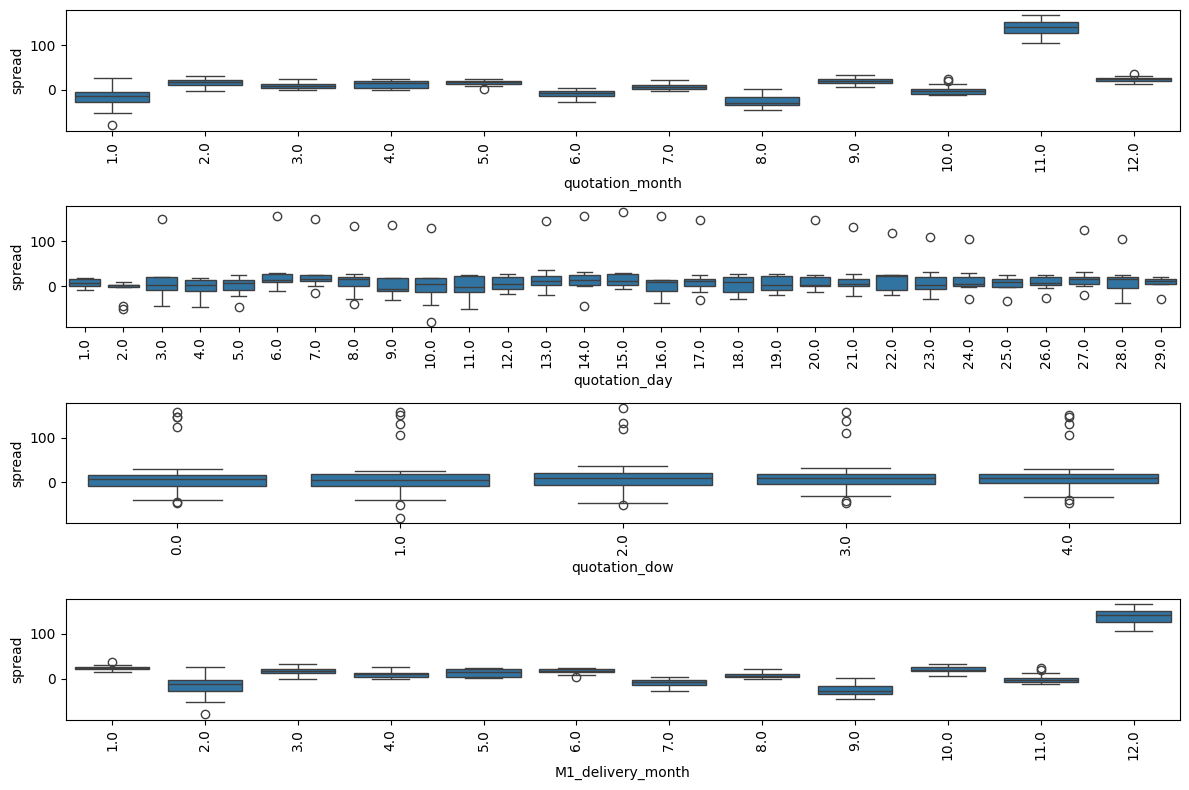

In [ ]:
plt.figure(figsize=(12, 8))

# quotation_month
plt.subplot(4, 1, 1)
sns.boxplot(x='quotation_month', y='spread', data=df_xgbr)
plt.xticks(rotation=90)

# quotation_day
plt.subplot(4, 1, 2)
sns.boxplot(x='quotation_day', y='spread', data=df_xgbr)
plt.xticks(rotation=90)

# quotation_dow
plt.subplot(4, 1, 3)
sns.boxplot(x='quotation_dow', y='spread', data=df_xgbr)
plt.xticks(rotation=90)

# M1_delivery_month
plt.subplot(4, 1, 4)
sns.boxplot(x='M1_delivery_month', y='spread', data=df_xgbr)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Boxplots without November - month that definitely stands out from the rest

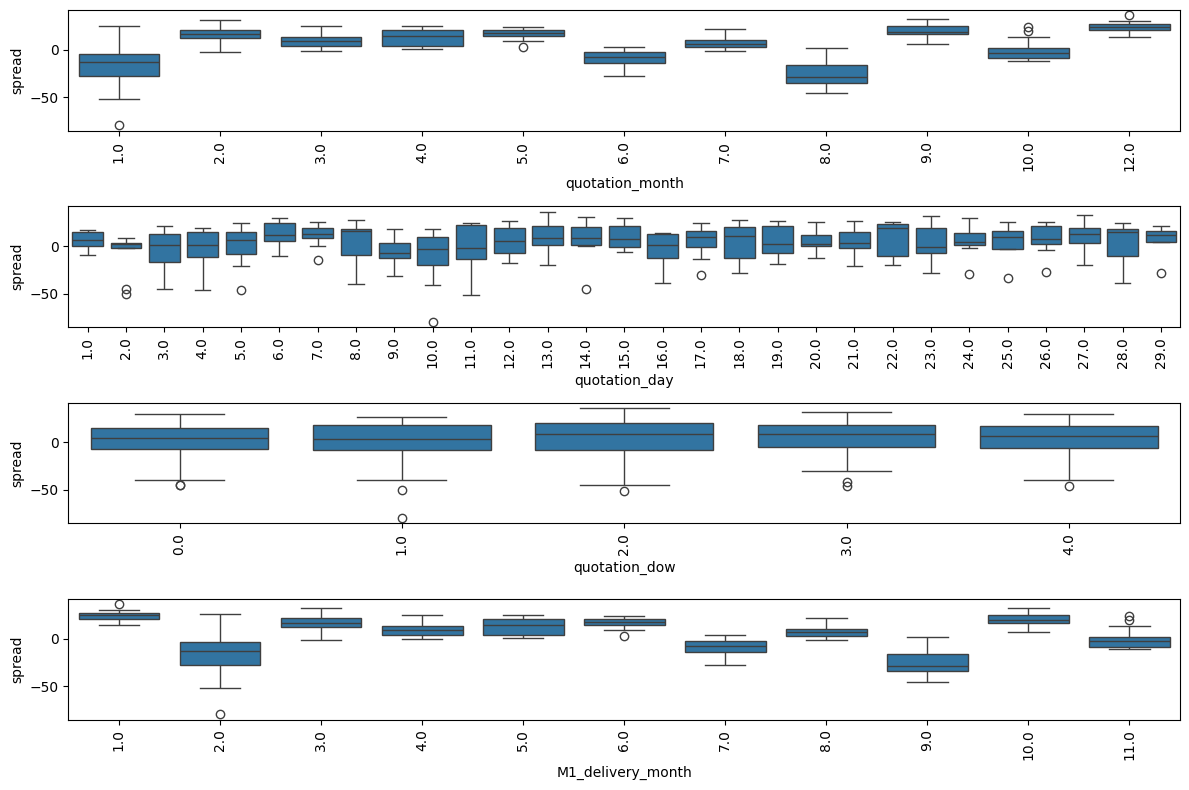

In [ ]:
plt.figure(figsize=(12, 8))

# quotation_month
plt.subplot(4, 1, 1)
sns.boxplot(x='quotation_month', y='spread', data=df_xgbr[df_xgbr['quotation_month'] != 11.0])
plt.xticks(rotation=90)

# quotation_day
plt.subplot(4, 1, 2)
sns.boxplot(x='quotation_day', y='spread', data=df_xgbr[df_xgbr['quotation_month'] != 11.0])
plt.xticks(rotation=90)

# quotation_dow
plt.subplot(4, 1, 3)
sns.boxplot(x='quotation_dow', y='spread', data=df_xgbr[df_xgbr['quotation_month'] != 11.0])
plt.xticks(rotation=90)

# M1_delivery_month
plt.subplot(4, 1, 4)
sns.boxplot(x='M1_delivery_month', y='spread', data=df_xgbr[df_xgbr['quotation_month'] != 11.0])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
features = ['quotation_month', 'quotation_day', 'quotation_dow', 'M1_delivery_month', 'settlement_price_M1']
YCOL = 'spread'

In [ ]:
horizon = 20
window_size = 60

train period: (0, 60)
test period: (60, 80)


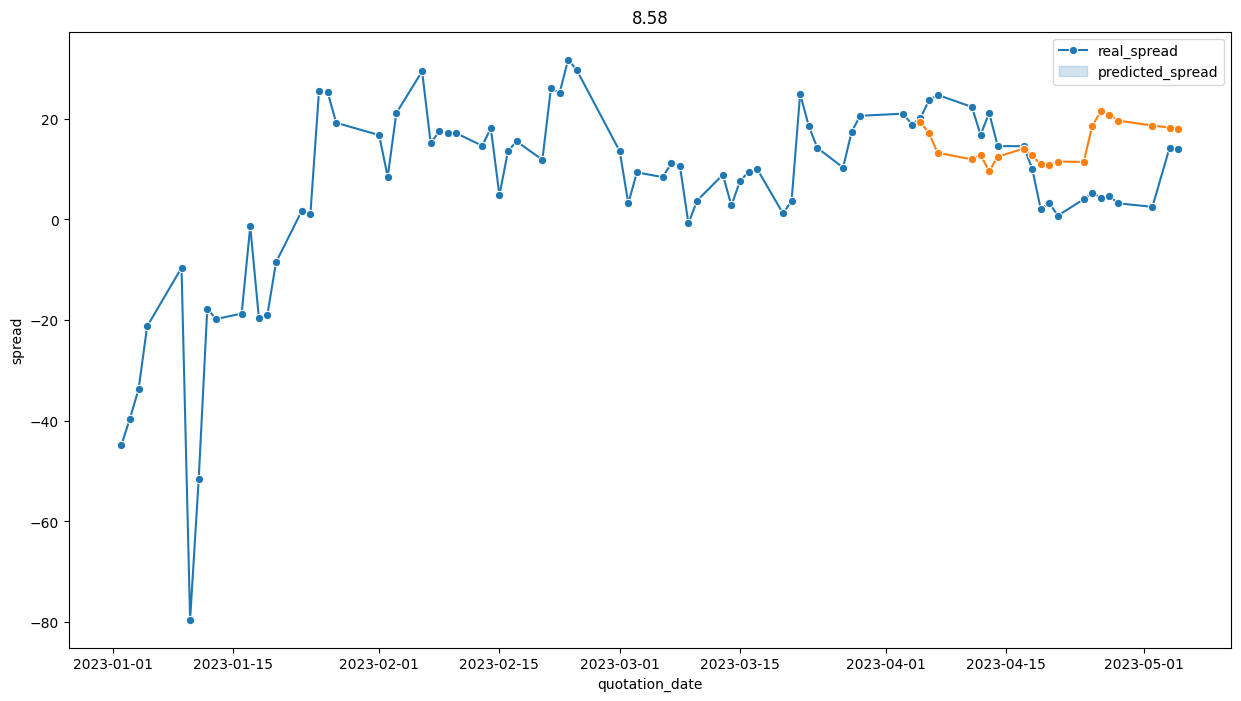

Mean absolute error for 20 days ahead forecast: 8.58216407394409
train period: (0, 80)
test period: (80, 100)


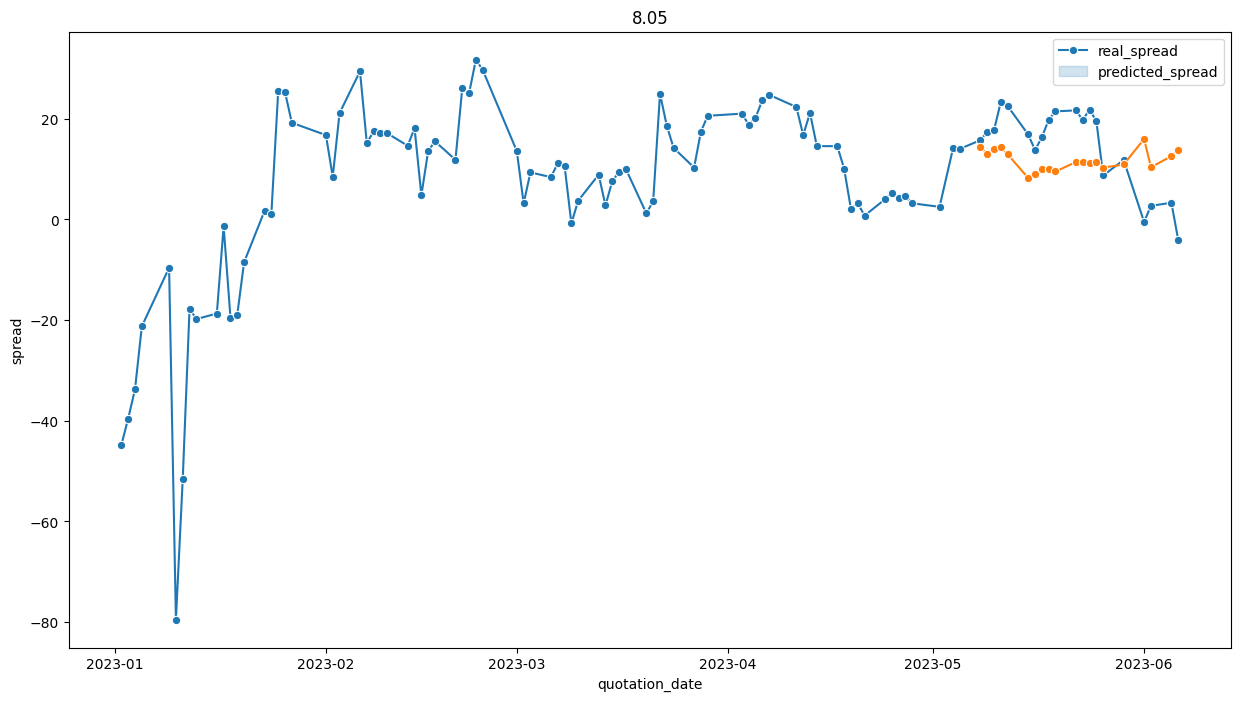

Mean absolute error for 20 days ahead forecast: 8.049245721817016
train period: (0, 100)
test period: (100, 120)


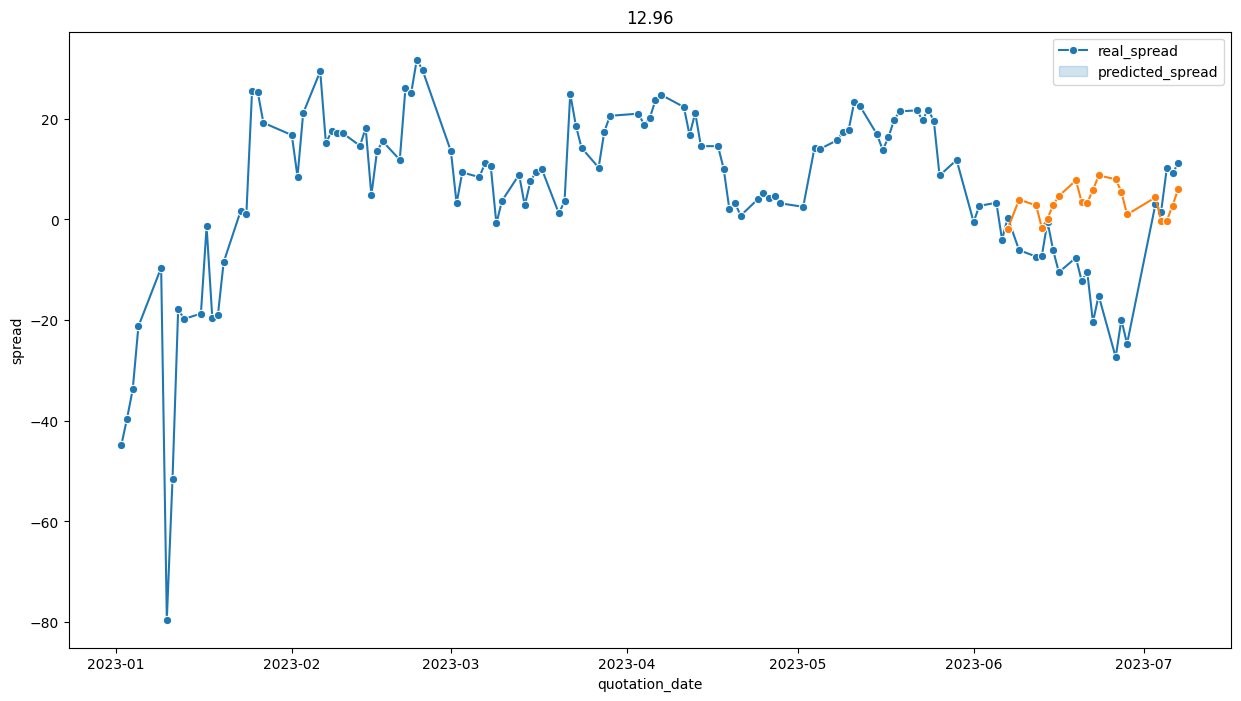

Mean absolute error for 20 days ahead forecast: 12.963713857263329
train period: (0, 120)
test period: (120, 140)


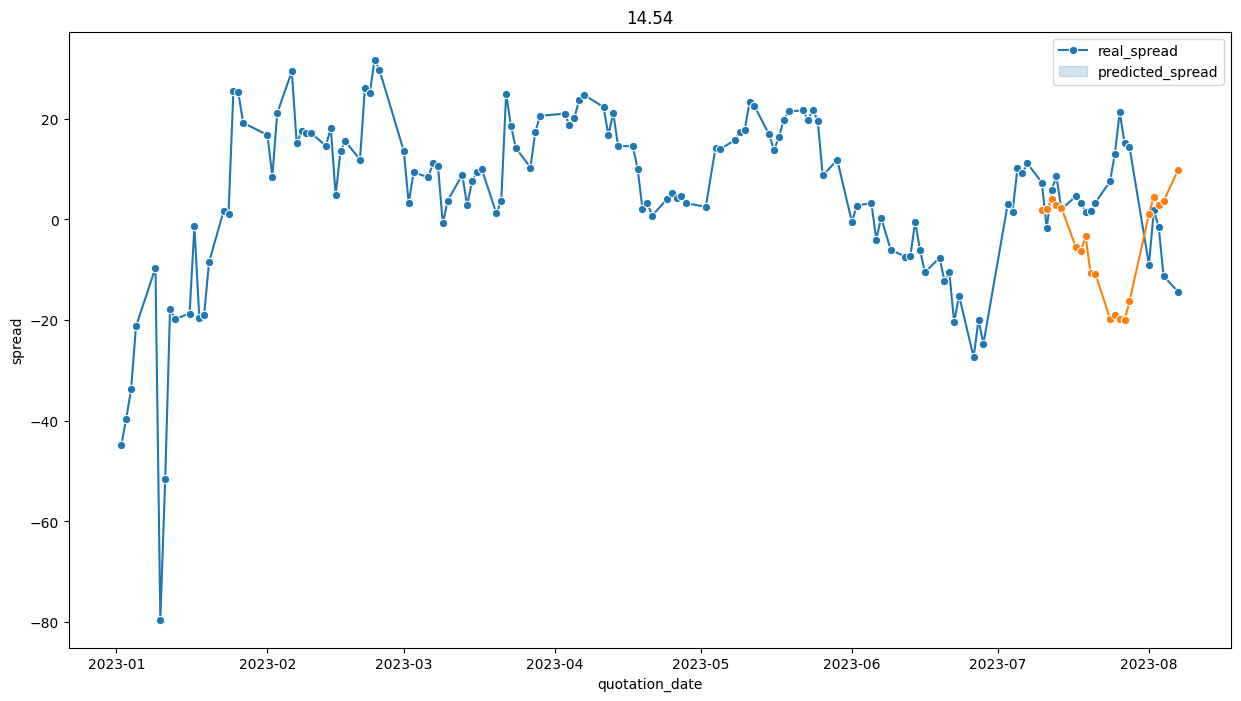

Mean absolute error for 20 days ahead forecast: 14.540172610998152
train period: (0, 140)
test period: (140, 160)


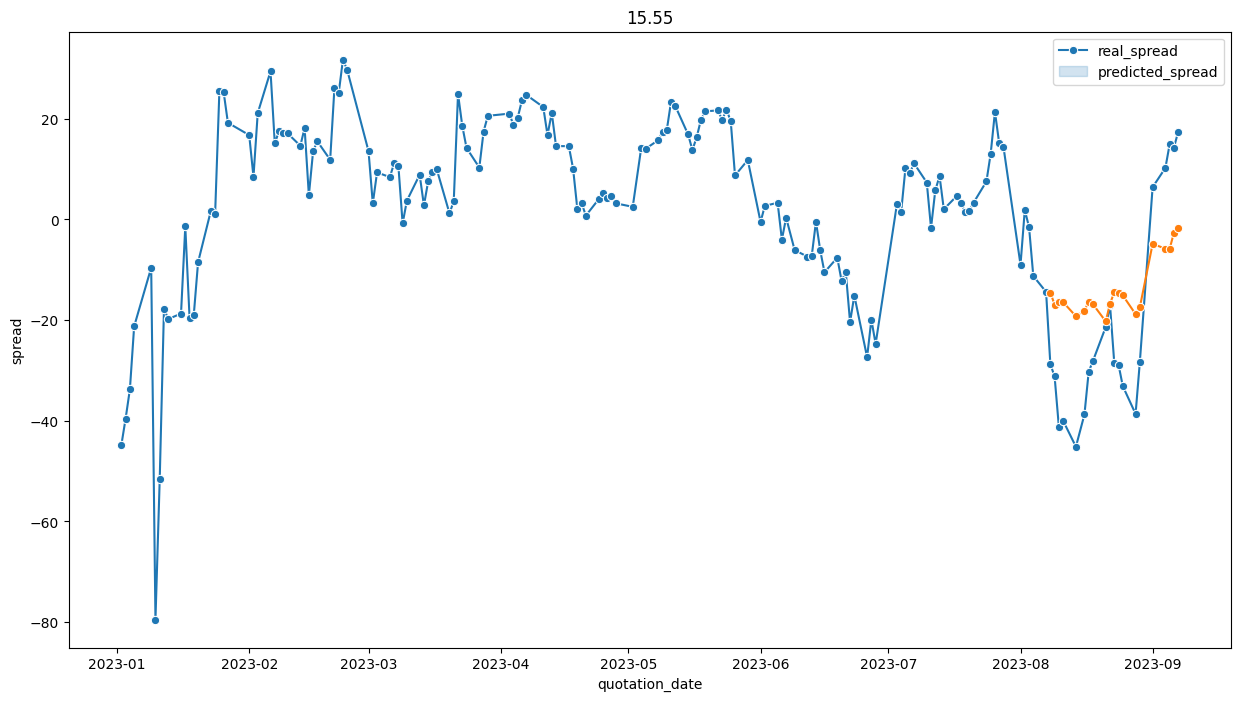

Mean absolute error for 20 days ahead forecast: 15.550510256052027
train period: (0, 160)
test period: (160, 180)


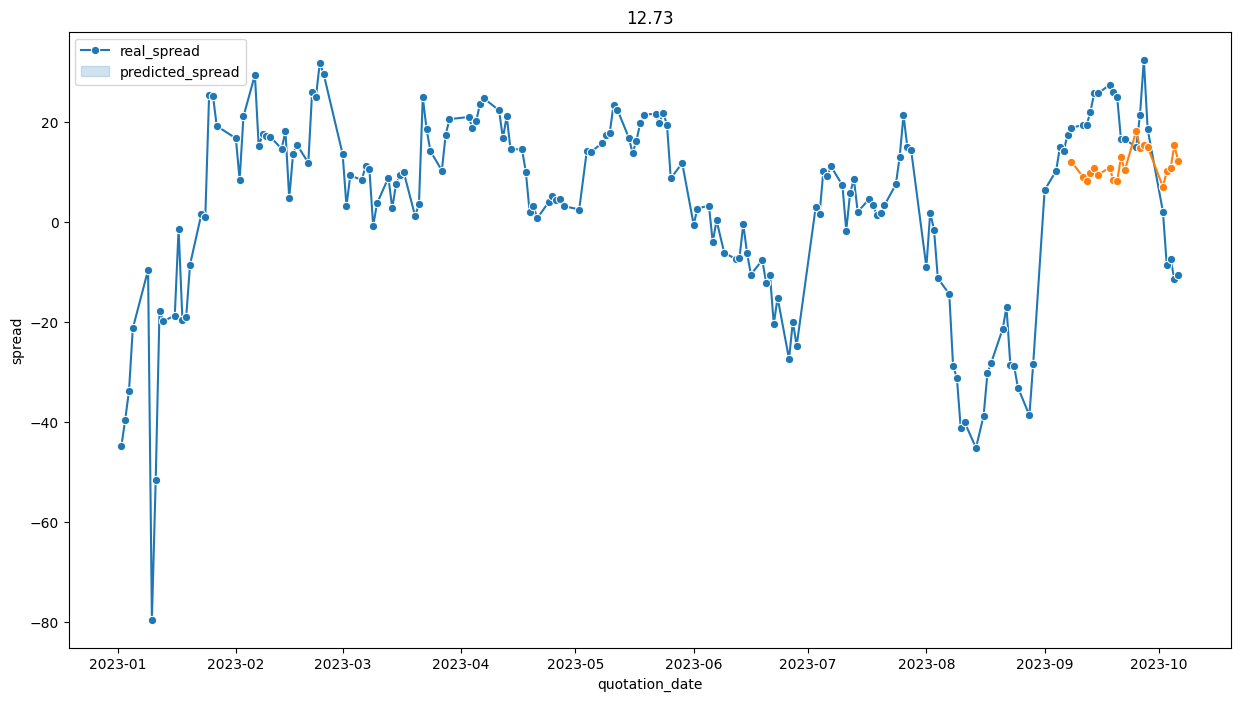

Mean absolute error for 20 days ahead forecast: 12.726091017723093
train period: (0, 180)
test period: (180, 200)


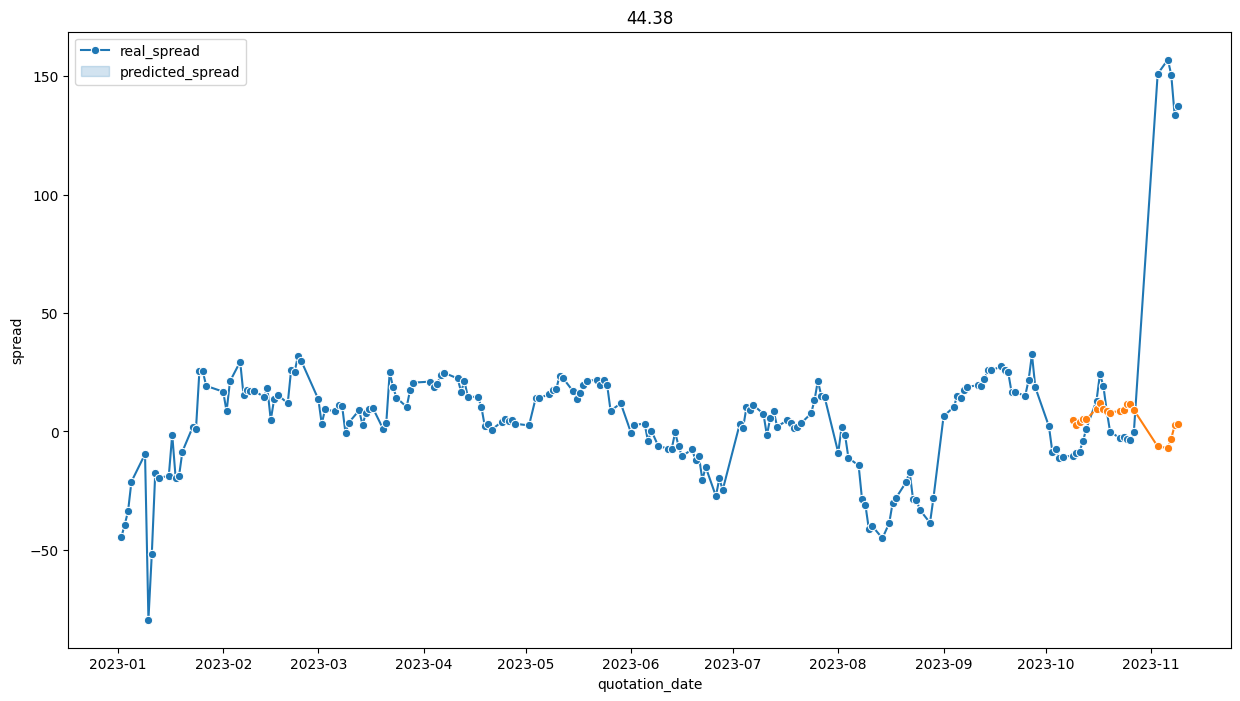

Mean absolute error for 20 days ahead forecast: 44.38082250642776
train period: (0, 200)
test period: (200, 220)


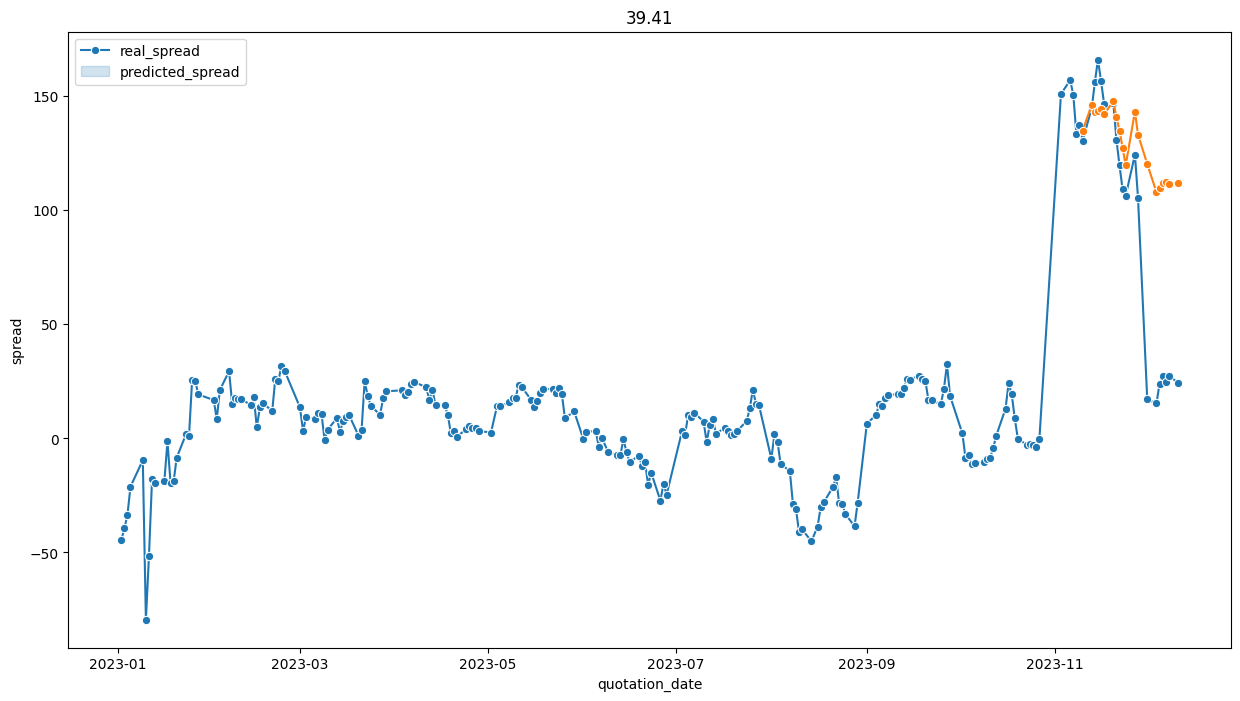

Mean absolute error for 20 days ahead forecast: 39.4078187866211
train period: (0, 220)
test period: (220, 240)


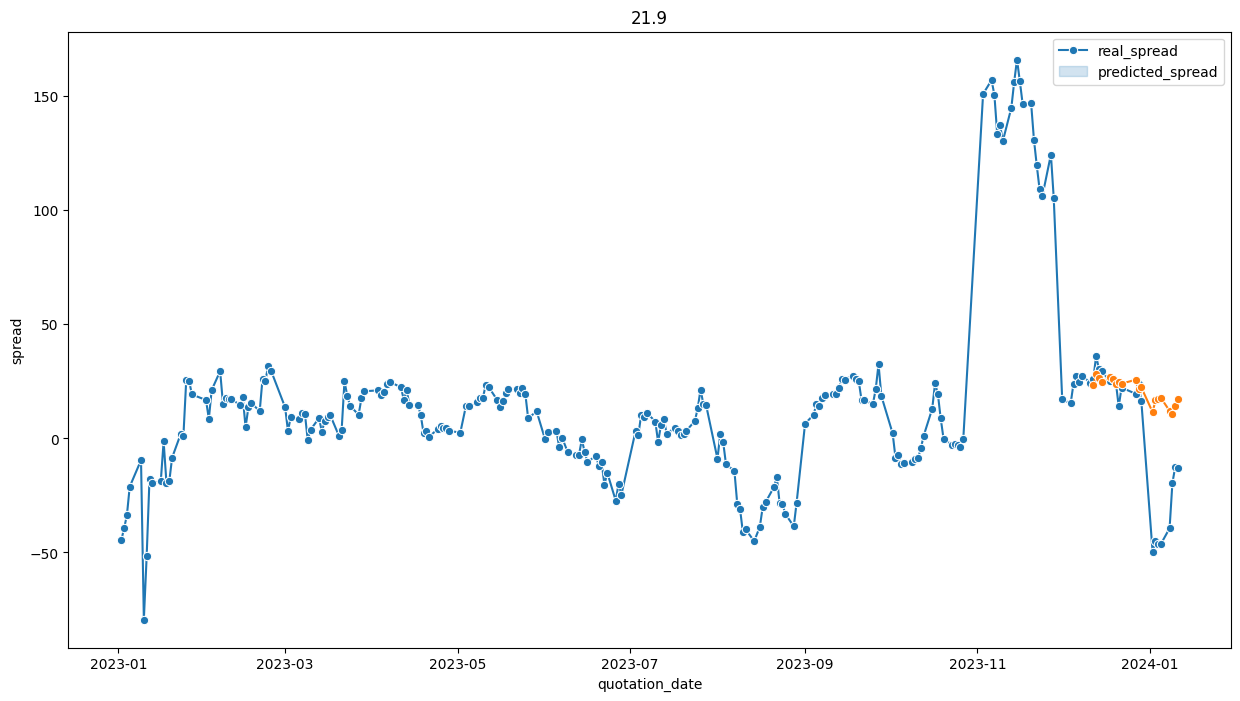

Mean absolute error for 20 days ahead forecast: 21.89631810569763


In [ ]:
maes_xgbr = []

for i in range(0, len(df_xgbr) - horizon - window_size, horizon):
  print(f"train period: {0, i + window_size}")
  print(f"test period: {i + window_size, i + window_size +horizon }")
  train = df_xgbr.iloc[0:i + window_size ]
  test = df_xgbr.iloc[i + window_size: i + window_size +horizon ]


  model = XGBRegressor(max_depth=5, n_estimators=100, random_state=0)
  model.fit(train[features], train[YCOL])

  forecast = model.predict(test[features])
  y_true = test[YCOL]

  test['pred_spread'] = forecast
  all = pd.concat([train, test])

  plt.figure(figsize = (15, 8))
  sns.lineplot(x = 'quotation_date', y = 'spread', data = all, marker = 'o' )
  sns.lineplot(x = 'quotation_date', y = 'pred_spread', data = all, marker = 'o' )
  plt.title(mae(y_true, forecast).round(2))
  plt.legend(['real_spread','predicted_spread'])
  plt.show()
  print(f'Mean absolute error for {horizon} days ahead forecast: {mae(y_true, forecast )}')

  maes_xgbr.append(mae(y_true, forecast))

In [ ]:
# 'Mean' MAE for all iterations
np.mean(maes_xgbr)

19.788539659616024

In [ ]:
np.median(maes_xgbr)

14.540172610998152

In [ ]:
np.percentile(maes_xgbr, 25)

12.726091017723093

In [ ]:
np.percentile(maes_xgbr, 75)

21.89631810569763

# Function that checks whether the spread statistically differs from the prediction

Let us establish that the spread is statistically over/understated when MAE > percentile(0.25)

In [ ]:
lim = np.percentile(maes_xgbr, 25)
lim

12.726091017723093

In [ ]:
def check_spread(df, date, lim_spread):
    features_to_spread = ['quotation_month', 'quotation_day', 'quotation_dow', 'settlement_price_M1']
    YCOL_spread = 'spread'
    train = df[df['quotation_date'] < date]
    test = df[df['quotation_date'] == date]

    model_spread = XGBRegressor(max_depth=5, n_estimators=100, random_state=0)
    model_spread.fit(train[features_to_spread], train[YCOL_spread])

    pred_spread = model_spread.predict(test[features_to_spread])
    real_spread = test[YCOL_spread]
    delta = real_spread.sub(pred_spread)
    if delta.values[0] > lim_spread:
        print('The spread is statistically inflated')
    elif delta.values[0] < -lim_spread:
        print('The spread is statistically low')
    else:
        print('The spread does not differ statistically from the norm')

In [ ]:
test_date = '2023-11-03'

In [ ]:
check_spread(df_xgbr, test_date, lim)

The spread is statistically inflated


# BUY/SELL Signal - having df and an example boundary and date, we receive a signal which contracts to sell/buy

In [ ]:
def delta_spread(df, date):
    features_to_spread = ['quotation_month', 'quotation_day', 'quotation_dow', 'settlement_price_M1']
    YCOL_spread = 'spread'
    train = df[df['quotation_date'] < date]
    test = df[df['quotation_date'] == date]

    model_spread = XGBRegressor(max_depth=5, n_estimators=100, random_state=0)
    model_spread.fit(train[features_to_spread], train[YCOL_spread])

    pred_spread = model_spread.predict(test[features_to_spread])
    real_spread = test[YCOL_spread]
    delta = real_spread.sub(pred_spread)
    return delta.values[0]

In [ ]:
def delta_price(df, date):
    features_to_price = ['quotation_month', 'quotation_day', 'quotation_dow', 'spread']
    YCOL_price = 'settlement_price_M1'
    train = df[df['quotation_date'] < date]
    test = df[df['quotation_date'] == date]

    model_price = XGBRegressor(max_depth=5, n_estimators=100, random_state=0)
    model_price.fit(train[features_to_price], train[YCOL_price])

    pred_price = model_price.predict(test[features_to_price])
    real_price = test[YCOL_price]
    delta = real_price - pred_price
    return delta.values[0]

In [ ]:
def buy_sell_signal(df, date, lim_spread):

    spread_delta = delta_spread(df, date)
    price_delta = delta_price(df, date)

    if spread_delta > lim_spread:
      if price_delta > lim_spread:
        print('SELL M+2 contract')
      else:
        print('BUY M+1 contract')
    elif spread_delta < -lim_spread:
      if price_delta > lim_spread:
        print('SELL M+1 contract')
      else:
        print('BUY M+2 contract')
    else:
      if price_delta > lim_spread:
        print('SELL M+1 & M+2 contract')
      elif price_delta < -lim_spread:
        print('BUY M+1 & M+2 contract')
      else:
        print("Don't do anything")


In [ ]:
buy_sell_signal(df_xgbr, test_date, lim)

BUY M+1 contract
